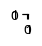

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

# init

In [2]:
import csv
def get_metadata(filename):
    # Initialize a dictionary to hold the header information
    metadatares = {'filename':os.path.basename(filename)}
    metadatares['relpath']=filename
    # Read the CSV file
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        # Read the first line which contains the metadata
        metadata_line = next(reader)[0]
        # Convert the metadata line to a dictionary
        metadata = eval(metadata_line)
    metadatares.update(metadata)
    return metadatares
    
def read_ots_data(filename):
    metadata = get_metadata(filename)
    df = pd.read_csv(filename, skiprows=1)
    df = df[[c for c in df.columns if ('aa' in c.lower() and 'cdr' in c.lower()) or 'call' in c.lower()]]
    df.columns = [x.replace('cdr','').replace('_aa_','').replace('beta','B').replace('alpha','A')[::-1] if 'cdr' in x else x for x in df.columns]
    df.columns = df.columns.str.replace('_call','')
    df['Link']=metadata['Link']
    df['Disease']=metadata['Disease']
    df['CancerType']=metadata['CancerType']
    df['Source']=metadata['TSource']
    df['Subject']=metadata['Subject']
    return df, metadata


def plot_prune_heatmap(values, threshold, title, 
                       filename=None, outdir='../output/240618_NestedKCV_CNNVAE/notebook_figs/',
                       sorted_dm=None,
                       cmap='vlag', color='g', addline=True):
    # prune and plot the heatmap
    f,ax = plt.subplots(1,2, figsize=(16,16), width_ratios=(16.5/17, 0.5/17))
    ax = ax.ravel()
    ax, cbar_ax = ax[0], ax[1]
    pruned = values.copy()
    mask = (pruned<=threshold).astype(int)
    pruned = pruned * mask
    sns.heatmap(pruned, ax=ax, square=True, vmin=0, vmax=values.max(), cbar_ax=cbar_ax, cmap=cmap)
    # Set up custom tickmarks if available
    if sorted_dm is not None:
        pepmap = sorted_dm.groupby('peptide').agg(count=('raw_index','count'))
        pepmap['idx']=pepmap['count'].cumsum()
        pepmap['tick']=pepmap['idx']-pepmap['count'].iloc[0]+3
        tickmarks = pepmap['tick'].to_dict() 
        idxs = pepmap['idx'].to_dict()
        ax.set_xticks(list(tickmarks.values()))
        ax.set_yticks(list(tickmarks.values()))
        ax.set_xticklabels(list(tickmarks.keys()), ha='center', fontweight='semibold', fontsize=15)
        ax.set_yticklabels(list(tickmarks.keys()), va='center', fontweight='semibold', fontsize=15)
    if addline and sorted_dm is not None:
        for k,v in idxs.items():
            ax.axhline(v, ls='--', lw=.9, c=color)
            ax.axvline(v, ls='--', lw=.9, c=color)
    # Rotate the tick labels for better readability (optional)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.set_title(title, fontweight='semibold', fontsize=17)
    f.tight_layout()
    if filename is not None:
        f.savefig(f'{outdir}{filename}.png', dpi=150, bbox_inches='tight')
    plt.close()
    del f, ax

def do_all(filename, model, noplot=False, unique=False, outdir='../output/240820_HumanRepertoires/'):
    df, metadata = read_ots_data(filename)
    df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
    if unique:
        df.drop_duplicates(subset=['tcr'], inplace=True)
    metadata['n_seq'] = len(df)
    metadata['n_unique'] = len(df['tcr'].unique())
    pd.DataFrame(metadata, index=[0]).to_csv(f"{outdir}metadata/{metadata['Run']}_metadata.txt", index=False)
    if noplot:
        return 0
    else:
            
        if len(glob.glob(f'{outdir}heatmaps/*{metadata["Run"]}*'))>0:
            return 0
    
        latent_df = get_latent_df(model, df)
        latent_df['index_col'] = [f'seq_{i:04}' for i in range(len(latent_df))]
        _, values_array, _, _, _, _ = get_distances_labels_from_latent(latent_df, 
                                                                       label_col='Disease', 
                                                                       index_col='index_col',
                                                                       rest_cols=['Disease','CancerType','Source'],
                                                                       low_memory=True)
        
        latent_df['tcr'] = latent_df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
        n_seq=len(latent_df)
        n_unique=len(latent_df['tcr'].unique())
        plot_prune_heatmap(values_array, threshold=10, title=f"{metadata['Run']}, n_seq={n_seq}, n_unique={n_unique}", 
                           filename=f'{metadata["Run"]}_n-{n_seq}_unique-{n_unique}',
                           outdir=f'{outdir}heatmaps/', addline=False, sorted_dm=None)
        print(metadata['Run'], '\t', n_seq, '\t', n_unique)
        del latent_df
    # latent_df.groupby(['tcr']).agg(count=('B1','count')).sort_values('count',ascending=False)

In [7]:
def read_ots_unique(filename):
    df, metadata = read_ots_data(filename)
    df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
    metadata['n_seq'] = len(df)
    metadata['unique'] = len(df.tcr.unique())
    counts = df.groupby('tcr').agg(count=('B3','count'))
    df = df.drop_duplicates(subset=['tcr'])
    df = df.set_index('tcr').merge(counts,left_index=True,right_index=True).reset_index()
    df['Run']=metadata['Run']
    return df, metadata

In [3]:
meta_df = pd.read_csv('../data/OTS/human/METADATA.txt')
meta_df.groupby(['Link','Author']).agg(disease=('Disease','unique'),
                                      n_repertoires=('Disease','count'),
                                      mean_size=('Sequences', 'mean'),
                                      mean_unique=('n_unique','mean'))

,,disease,n_repertoires,mean_size,mean_unique
Link,Author,,,,
https://pubmed.ncbi.nlm.nih.gov/33478949/,Kusnadi et al. 2021,[covid],15,4657.133333,734.266667
https://pubmed.ncbi.nlm.nih.gov/34156975/,"Peng et al., 2021",[herpes_simplex_virus_type_2],4,1324.250000,681.250000
https://pubmed.ncbi.nlm.nih.gov/34793243/,Francis et al. 2021,[covid],95,1655.589474,821.357895
https://pubmed.ncbi.nlm.nih.gov/36516854/,Yu et al. 2022,[cmv],6,2545.833333,733.500000
https://pubmed.ncbi.nlm.nih.gov/37580605/,Garner et al.,[healthy],96,5587.364583,1663.104167
https://www.nature.com/articles/s41590-022-01367-z,Xu et al. 2023,[covid],8,4370.750000,3346.875000
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10201342/,Eberhardt et al. 2021,[cancer],51,1234.333333,191.705882


# re-make francis healthy data with low healthy counts

# Do run merging Covid (Francis) and Healthy (Garner) studies

## save with low counts

<Axes: title={'center': 'Garner Healthy'}, ylabel='Frequency'>

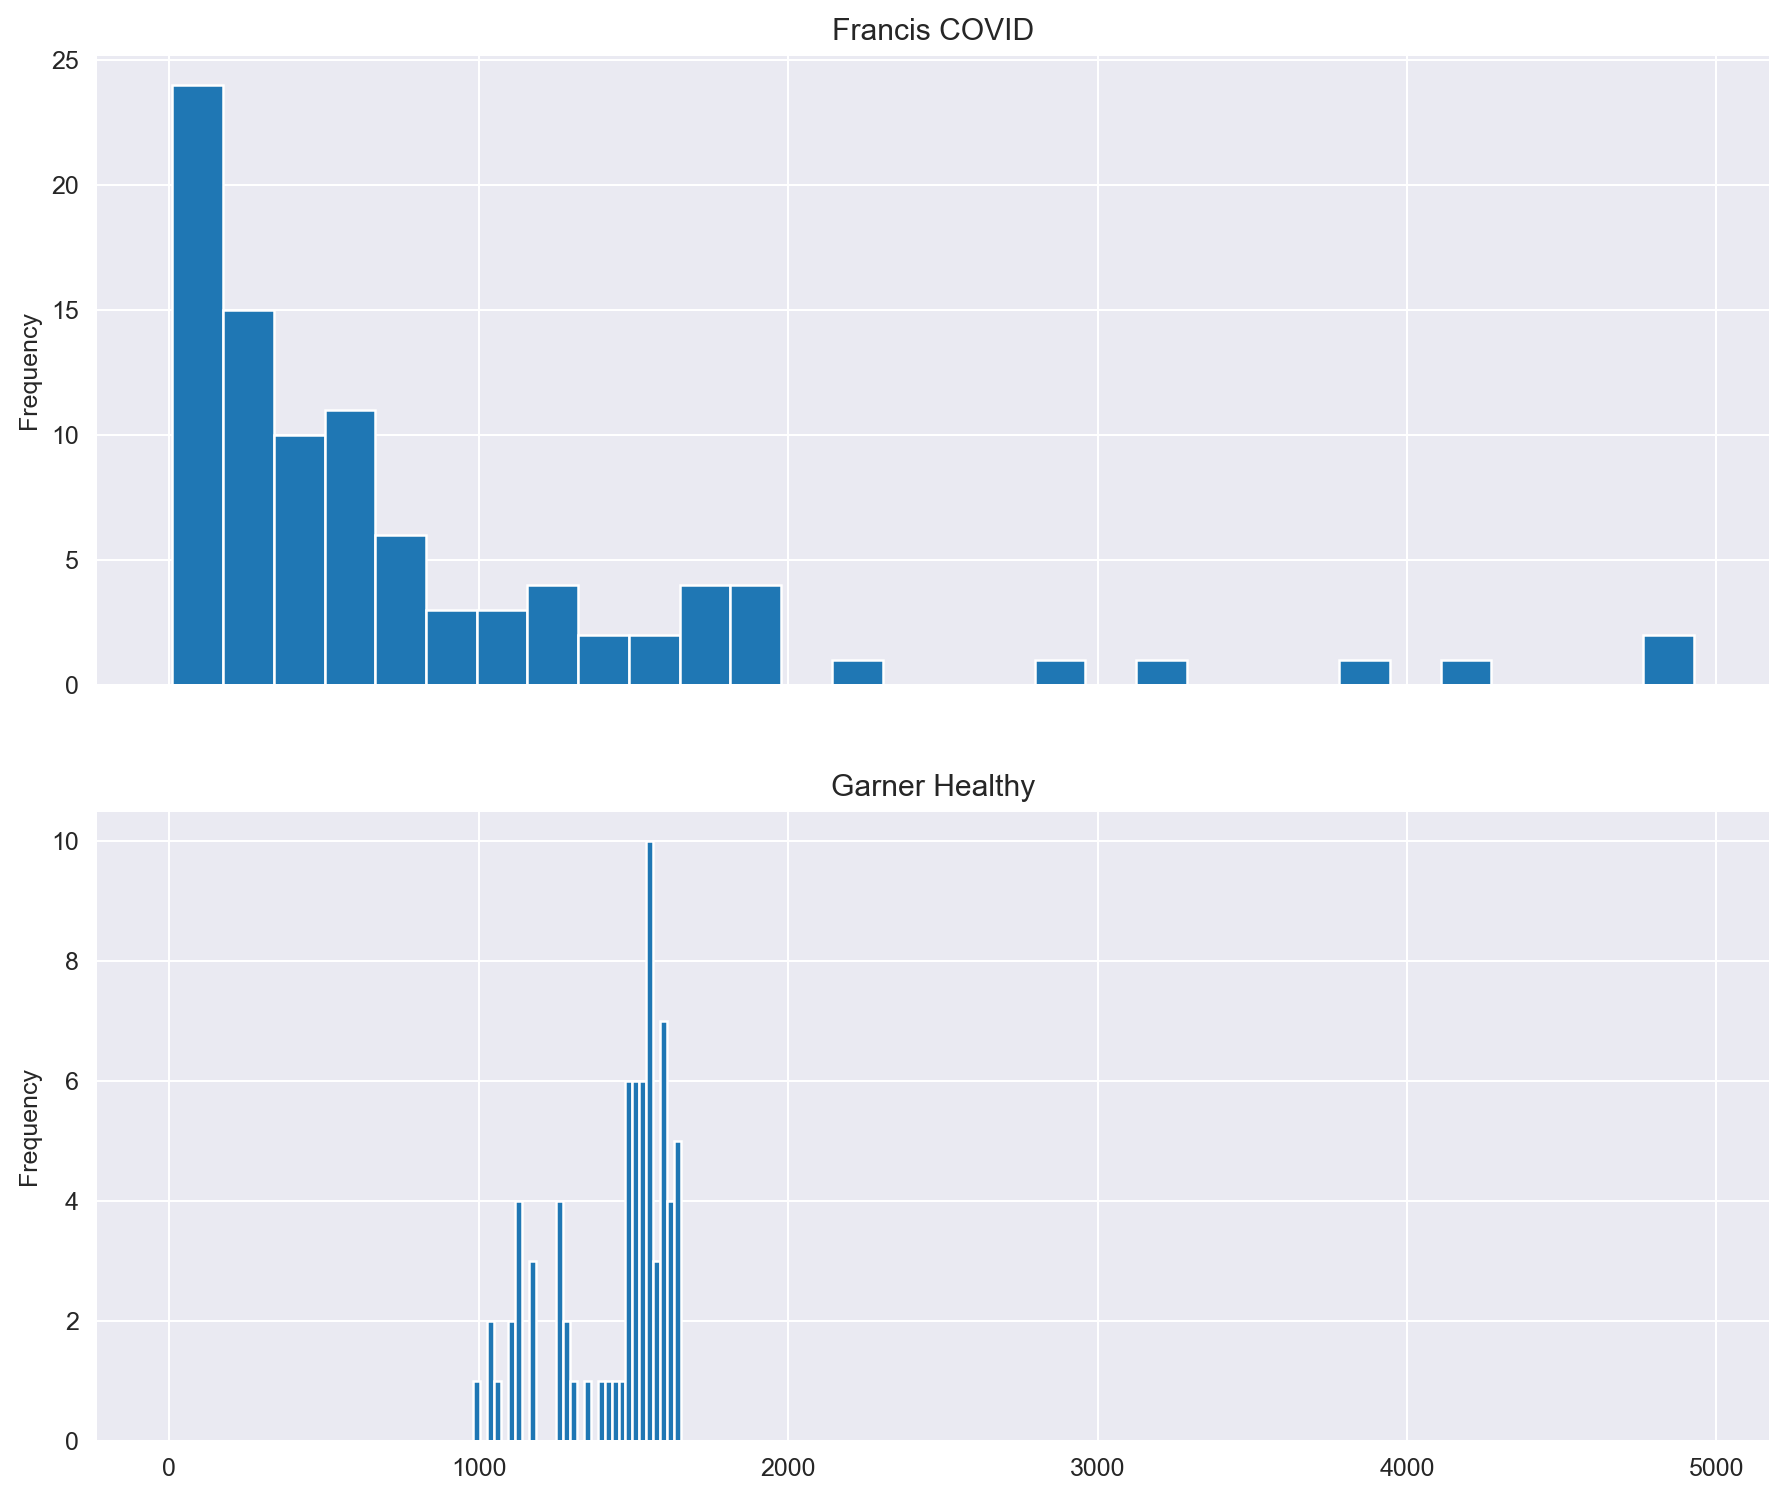

In [9]:
garner_pbmc = meta_df.query('Author.str.contains("Garner")').query('TSource=="pbmc"')
francis_pbmc = meta_df.query('Author.str.contains("Franc")')
f,a = plt.subplots(2,1, figsize=(12,10), sharex=True)
ax = a.ravel()
francis_pbmc.n_unique.plot(kind='hist', bins=30, ax = ax[0], title='Francis COVID')
garner_pbmc.n_unique.plot(kind='hist', bins=30, ax = ax[1], title='Garner Healthy')

In [16]:
%mkdir ../data/OTS/subsampled_covid_healthy_lowcount/
garner_3 = pd.read_csv('../data/OTS/garner_merged/garner_merged_41_42_43.csv').query('mean_count<2')
garner_3.query('mean_count==1')

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,...,CancerType,Source,Subject,count,Run,duplicated,n_dupes,mean_count,max_count,index_col
0,ATGYPSATKADDKAFMDTGRRALTSGHTAFQGTGAASSQVGGGTDTQY,TRBV7-3*01,TRBD2*01,TRBJ2-3*01,SGHTA,FQGTGA,ASSQVGGGTDTQY,TRAV9-2*01,NaN,TRAJ5*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409126,True,6.0,1.0,1.0,garner_00000
2,ATGYPSATKADDKALCLYGGATNKLIMNHNYSVGAGIASSPTELPS...,TRBV6-6*01,TRBD2*02,TRBJ2-7*01,MNHNY,SVGAGI,ASSPTELPSYEQY,TRAV9-2*02,NaN,TRAJ32*02,...,none,pbmc,4.1_4.2_4.3,1,SRR25409221,True,3.0,1.0,1.0,garner_00002
3,ATGYPSATKADDKALESSGGSYIPTDFQATTSNEGSKASAIHLERA...,TRBV20-1*01,TRBD2*01,TRBJ2-7*01,DFQATT,SNEGSKA,SAIHLERAGEQY,TRAV9-2*01,NaN,TRAJ6*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409234,True,7.0,1.0,1.0,garner_00003
5,ATGYPSATKADDKALFQAGTALIDFQATTSNEGSKASASSGSSYNEQF,TRBV20-1*01,TRBD2*02,TRBJ2-1*01,DFQATT,SNEGSKA,SASSGSSYNEQF,TRAV9-2*02,NaN,TRAJ15*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409167,True,4.0,1.0,1.0,garner_00005
6,ATGYPSATKADDKALGSKTSYDKVISGHNTYENEEAASSLDFTGAR...,TRBV11-3*01,TRBD1*01,TRBJ2-2*01,SGHNT,YENEEA,ASSLDFTGARTGELF,TRAV9-2*02,NaN,TRAJ50*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409111,True,5.0,1.0,1.0,garner_00006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,YSGSPEHISRAPFSGGYNKLILNHDASQIVNDASSIDPGSGADTQY,TRBV19*01,TRBD1*01,TRBJ2-3*01,LNHDA,SQIVND,ASSIDPGSGADTQY,TRAV16*01,NaN,TRAJ4*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409234,True,21.0,1.0,1.0,garner_09999
10000,YSGSPEHISRAPGGYQKVTMNHNSSASEGTASSEAPELGEQY,TRBV6-1*01,NaN,TRBJ2-7*01,MNHNS,SASEGT,ASSEAPELGEQY,TRAV16*01,NaN,TRAJ13*02,...,none,pbmc,4.1_4.2_4.3,1,SRR25409180,True,4.0,1.0,1.0,garner_10000
10001,YSGSPEHISRAPHTGGFKTIMDHENSYDVKMASSPGQRDTGELF,TRBV28*01,TRBD1*01,TRBJ2-2*01,MDHEN,SYDVKM,ASSPGQRDTGELF,TRAV16*01,NaN,TRAJ9*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409121,True,3.0,1.0,1.0,garner_10001
10004,YSGSPEHISRASSDGQKLLMNHNSSASEGTASTSLGGSVGELF,TRBV6-1*01,TRBD1*01,TRBJ2-2*01,MNHNS,SASEGT,ASTSLGGSVGELF,TRAV16*01,NaN,TRAJ16*02,...,none,pbmc,4.1_4.2_4.3,1,SRR25409232,True,12.0,1.0,1.0,garner_10004


In [18]:
garner_3 = garner_3.query('mean_count==1')

In [26]:
def save_sub(fr, garner_3, seed):
    fn=f'../data/OTS/subsampled_covid_healthy_lowcount/subsampled_francis_{i:03}_seed_{seed:03}.txt'
    if os.path.exists(fn):
        df = pd.read_csv(fn)
        return (fn, df.duplicated(['tcr']).any())
    sub = garner_3.sample(n=len(fr), random_state=seed)
    cat = pd.concat([fr, sub]).reset_index(drop=True)
    cat['norm_count'] = cat.apply(lambda x: x['count'] / cat.groupby(['Disease'])['count'].sum()[x['Disease']], axis=1)

    cat.to_csv(f'../data/OTS/subsampled_covid_healthy_lowcount/subsampled_francis_{i:03}_seed_{seed:03}.txt', index=False)
    return (fn, cat.duplicated(['tcr']).any())


In [34]:
%ls ../data/OTS/subsampled_covid_healthy_lowcount

subsampled_francis_000_seed_000.txt  subsampled_francis_021_seed_050.txt
subsampled_francis_000_seed_001.txt  subsampled_francis_021_seed_051.txt
subsampled_francis_000_seed_002.txt  subsampled_francis_021_seed_052.txt
subsampled_francis_000_seed_003.txt  subsampled_francis_021_seed_053.txt
subsampled_francis_000_seed_004.txt  subsampled_francis_021_seed_054.txt
subsampled_francis_000_seed_005.txt  subsampled_francis_021_seed_055.txt
subsampled_francis_000_seed_006.txt  subsampled_francis_021_seed_056.txt
subsampled_francis_000_seed_007.txt  subsampled_francis_021_seed_057.txt
subsampled_francis_000_seed_008.txt  subsampled_francis_021_seed_058.txt
subsampled_francis_000_seed_009.txt  subsampled_francis_021_seed_059.txt
subsampled_francis_000_seed_010.txt  subsampled_francis_021_seed_060.txt
subsampled_francis_000_seed_011.txt  subsampled_francis_021_seed_061.txt
subsampled_francis_000_seed_012.txt  subsampled_francis_021_seed_062.txt
subsampled_francis_000_seed_013.txt  subsampled_fra

In [27]:
from joblib import Parallel, delayed
# Stop at 43 because that gives us a dataframe with 1521 seq and that's largest we could run without taking 16 hours
for i in tqdm(range(44), desc='i'):
    fr = pd.read_csv(f'../data/OTS/francis_covid/francis_{i:04}.txt', index_col=0)
    out=Parallel(n_jobs=10)(delayed(save_sub)(fr, garner_3.query('tcr not in @fr.tcr.unique()'), 
                                              seed) for seed in tqdm(range(100),leave=False,position=0))

mkdir: ../data/OTS/subsampled_francis_garner/: File exists


i:   0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## Results

# QVD/KSA/exp_df similarities?

In [48]:
exp_df = pd.read_csv('../data/filtered/240326_nettcr_paired_NOswaps.csv')
train_df = exp_df.query('partition!=0 and partition!=1')
cancer = pd.concat([pd.read_csv(x) for x in glob.glob('../data/OTS/eberhardt_cancer/*.txt')])
cancer['peptide'] = cancer['TSubtype'].apply(lambda x: 'QVD' if 'qvd' in x.lower() else 'KSA')
cancer.head()

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,...,Link,Disease,CancerType,Source,Subject,count,Run,TSubtype,index_col,peptide
0,YGATPYYFSGDTLVAVGATLTGNQFYSEHNRFQNEAQASSPGGETG...,TRBV7-9*03,TRBD1*01,TRBJ2-3*01,SEHNR,FQNEAQ,ASSPGGETGGIEDTQY,TRAV8-3*01,NaN,TRAJ49*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,4,SRR15178231,tetramer_ksa,hpv51_ksa_000,KSA
1,TSESDYYQEAYKQQNAYRSAGAQKLVMGHRAYSYEKLASSLEGRDL...,TRBV4-1*01,TRBD1*01,TRBJ2-1*01,MGHRA,YSYEKL,ASSLEGRDLIFEQF,TRAV38-2/DV8*01,NaN,TRAJ54*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,5,SRR15178231,tetramer_ksa,hpv51_ksa_001,KSA
2,SSYSPSYTSAATLVVVSDRNSAGNKLTSEHNRFQNEAQASSSQTSG...,TRBV7-9*03,TRBD2*01,TRBJ2-5*01,SEHNR,FQNEAQ,ASSSQTSGGGETQY,TRAV8-2*01,NaN,TRAJ17*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,1,SRR15178231,tetramer_ksa,hpv51_ksa_002,KSA
3,SIFNTLYKAGELAGQLRGSGNTPLVSGHTAFQGTGAASSLGTSMDTQY,TRBV7-3*01,TRBD2*01,TRBJ2-3*01,SGHTA,FQGTGA,ASSLGTSMDTQY,TRAV35*01,NaN,TRAJ29*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,1,SRR15178233,tetramer_ksa,hpv51_ksa_003,KSA
4,YGATPYYFSGDTLVAVGVTLTGNQFYSEHNRFQNEAQASSPGGETG...,TRBV7-9*03,TRBD1*01,TRBJ2-3*01,SEHNR,FQNEAQ,ASSPGGETGGIEDTQY,TRAV8-3*01,NaN,TRAJ49*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,1,SRR15178233,tetramer_ksa,hpv51_ksa_004,KSA


In [49]:
pd.concat([cancer.assign(dataset='cancer_mixed'), train_df.assign(dataset='exp_train')]).to_csv('../data/OTS/cancer_train_mixed.csv')


# 